In [10]:
import pandas as pd
import torch
import timm
from torchvision import transforms
from PIL import Image



In [ ]:
# ========== Config ==========
img_size = 224
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image_folder = '../data/data/test'  # Folder with test images
csv_path = '../data/data/test_ids.csv'         # Your CSV with image IDs
model_path = '../trained_model/vit_soil_classifier_weights_after_aug_20epoch.pth' # Your trained model
class_names = ['Alluvial soil', 'Black Soil', 'Clay soil', 'Red soil']




In [12]:
# ========== Load CSV ==========
df = pd.read_csv(csv_path)

# ========== Transform ==========
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ========== Load Model ==========
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()



C:\Users\bkesh\AppData\Local\Temp\ipykernel_17096\1806429263.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [13]:
# ========== Predict Function ==========
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        pred = torch.argmax(outputs, dim=1).item()
    return class_names[pred]



In [14]:
# ========== Predict All Images ==========
soil_types = []
for image_id in df['image_id']:
    image_path = f"{image_folder}/{image_id}"
    soil_type = predict_image(image_path)
    soil_types.append(soil_type)



In [15]:
# ========== Save to CSV ==========
df['soil_type'] = soil_types
df.to_csv('predicted_soil_types_after_20_epochs.csv', index=False)
print("Predictions saved to predicted_soil_types.csv")

Predictions saved to predicted_soil_types.csv


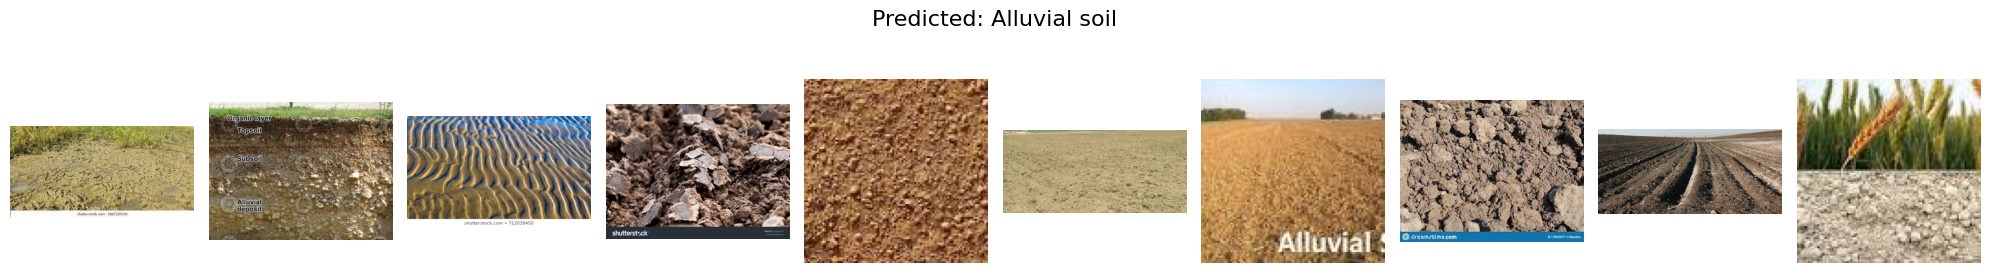

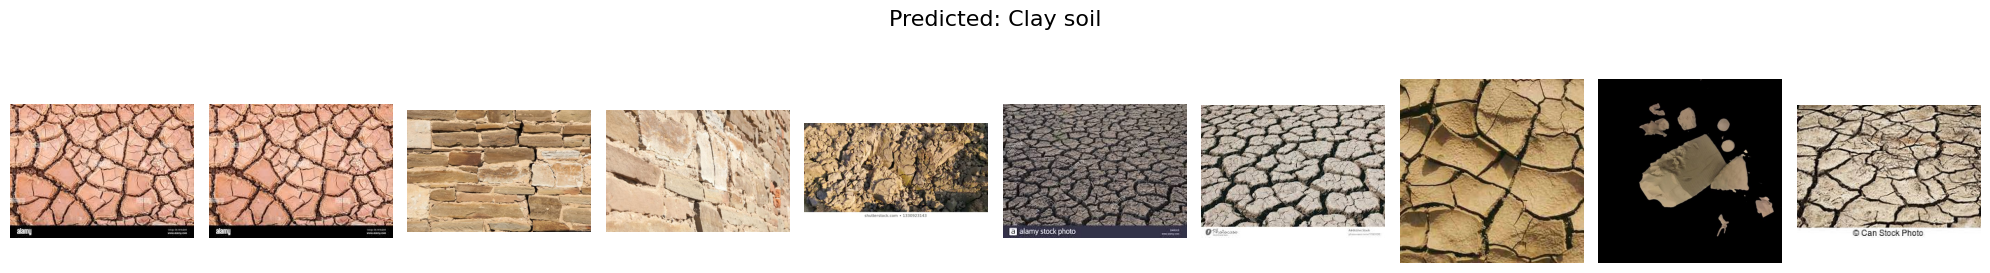

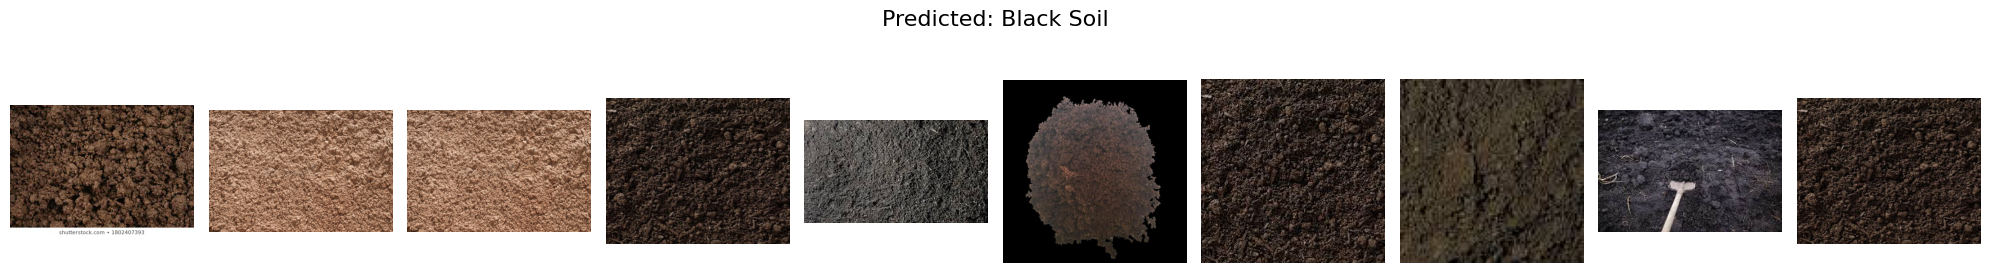

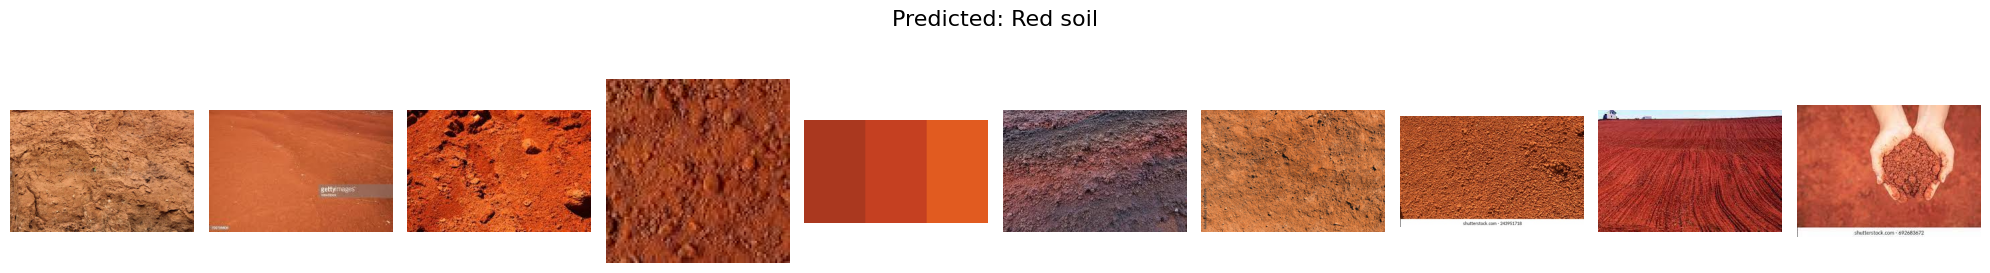

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# ========== Parameters ==========
num_per_class = 10
image_folder = image_folder

# ========== Plotting ==========
classes = df['soil_type'].unique()

for soil_type in classes:
    class_images = df[df['soil_type'] == soil_type].head(num_per_class)
    fig, axes = plt.subplots(1, num_per_class, figsize=(20, 3))
    fig.suptitle(f"Predicted: {soil_type}", fontsize=16)
    
    for i, (idx, row) in enumerate(class_images.iterrows()):
        img_path = os.path.join(image_folder, row['image_id'])
        image = Image.open(img_path).convert("RGB")
        axes[i].imshow(image)
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()
